# Standard U-Net: Baseline Model for Tumor Segmentation + Classification

This notebook implements a **single, standard U-Net** with dual outputs (segmentation + classification) as a baseline to compare against Co-DeepNet.

## Goal: Prove Co-DeepNet's Superiority

According to the research paper, **two smaller cooperative networks should outperform one larger network**:
- Better accuracy with less computational cost
- More efficient exploration of solution space
- Better generalization through network diversity

This baseline will help us verify these claims!

## Architecture Overview:
```
Input → [Single U-Net] → {Classification, Segmentation}
```

vs Co-DeepNet:
```
Input → [U-Net-A] ⟷ Knowledge Transfer ⟷ [U-Net-B] → Ensemble → {Classification, Segmentation}
```

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.7.1+cu118


## 2. Standard U-Net Architecture with Dual Output

Same architecture as Co-DeepNet's individual networks, but trained as a single model.

In [2]:
class DoubleConv(nn.Module):
    """(Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class StandardUNet(nn.Module):
    """
    Standard U-Net with dual output (baseline for comparison).
    
    Outputs:
    - Segmentation: Pixel-level tumor mask
    - Classification: Binary tumor presence
    """
    def __init__(self, in_channels=1, seg_classes=1):
        super().__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Classification Head (from bottleneck features)
        self.clf_pool = nn.AdaptiveAvgPool2d(1)
        self.clf_fc = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 1)  # Binary classification
        )
        
        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Segmentation Output
        self.seg_out = nn.Conv2d(64, seg_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Classification Branch
        clf_features = self.clf_pool(bottleneck)
        clf_features = clf_features.view(clf_features.size(0), -1)
        clf_logits = self.clf_fc(clf_features)
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Segmentation Output
        seg_logits = self.seg_out(dec1)
        
        return seg_logits, clf_logits
    
    def count_parameters(self):
        """Count total trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Initialize model
standard_unet = StandardUNet(in_channels=1, seg_classes=1).to(device)
num_params = standard_unet.count_parameters()

print(f"\n✓ Standard U-Net initialized")
print(f"  Total parameters: {num_params:,}")
print(f"  Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB (fp32)")


✓ Standard U-Net initialized
  Total parameters: 31,305,026
  Model size: ~119.42 MB (fp32)


## 3. Dataset Loading (Same as Co-DeepNet)

In [ ]:
class TumorSegmentationDataset(Dataset):
    """Dataset for MIP-PET tumor images (same as Co-DeepNet)"""
    def __init__(self, data_dir: str, split='train', include_controls=True, include_patients=True):
        self.data_dir = Path(data_dir)
        self.samples = []
        
        print(f"Loading dataset from: {self.data_dir}")
        
        # Load controls
        if include_controls:
            control_dir = self.data_dir / 'controls' / 'imgs'
            if control_dir.exists():
                self.control_files = sorted(list(control_dir.glob('*.png')))
                print(f"  Controls: {len(self.control_files)} PNG files")
                for img_path in self.control_files:
                    self.samples.append((img_path, None, 0))
            else:
                self.control_files = []
        else:
            self.control_files = []
        
        # Load patients
        if include_patients:
            patient_img_dir = self.data_dir / 'patients' / 'imgs'
            patient_label_dir = self.data_dir / 'patients' / 'labels'
            
            if patient_img_dir.exists():
                self.patient_files = sorted(list(patient_img_dir.glob('*.png')))
                print(f"  Patients: {len(self.patient_files)} PNG files")
                
                found_labels = 0
                for img_path in self.patient_files:
                    img_stem = img_path.stem
                    possible_label_names = [
                        img_path.name,
                        img_stem + '.png',
                        img_stem.replace('patient_', 'segmentation_') + '.png',
                    ]
                    
                    label_path = None
                    for label_name in possible_label_names:
                        test_path = patient_label_dir / label_name
                        if test_path.exists():
                            label_path = test_path
                            break
                    
                    if label_path:
                        self.samples.append((img_path, label_path, 1))
                        found_labels += 1
                
                print(f"  Matched labels: {found_labels}")
            else:
                self.patient_files = []
        else:
            self.patient_files = []
        
        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])
        
        print(f"\n✓ Dataset Summary:")
        print(f"  Controls: {num_controls} | Patients: {num_patients} | Total: {len(self.samples)}")
        print(f"  Class balance: {num_patients/(num_controls+num_patients)*100:.1f}% positive")
    
    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)
    
    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]
        
        image = self._load_image(img_path)
        if image.max() > 1.0:
            image = image / 255.0
        
        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)
        
        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)
        
        return image, mask, clf_label


# Load dataset (same paths as Co-DeepNet)
print("="*70)
print("🔍 LOADING AUGMENTED DATASET")
print("="*70)

possible_paths = [
    Path('/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    if path.exists() and (path / 'controls' / 'imgs').exists():
        DATA_DIR = path
        print(f"✓ Found data at: {DATA_DIR}\n")
        break

if DATA_DIR is None:
    raise FileNotFoundError("Augmented data directory not found!")

train_dataset = TumorSegmentationDataset(str(DATA_DIR))
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)

print(f"\n✓ DataLoader ready: {len(train_loader)} batches")


🔍 LOADING AUGMENTED DATASET
✓ Found data at: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data

Loading dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data
  Controls: 426 PNG files
  Patients: 182 PNG files
  Matched labels: 182

✓ Dataset Summary:
  Controls: 426 | Patients: 182 | Total: 608
  Class balance: 29.9% positive

✓ DataLoader ready: 76 batches


## 4. Training Setup

In [4]:
# Training configuration (same as Co-DeepNet for fair comparison)
NUM_EPOCHS = 20
LEARNING_RATE = 1e-4
SEG_WEIGHT = 1.0
CLF_WEIGHT = 0.5

# Optimizer
optimizer = torch.optim.Adam(standard_unet.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss functions
seg_criterion = nn.BCEWithLogitsLoss()
clf_criterion = nn.BCEWithLogitsLoss()

# Training history
history = {
    'total_loss': [],
    'seg_loss': [],
    'clf_loss': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Seg weight: {SEG_WEIGHT}, Clf weight: {CLF_WEIGHT}")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 20
  Learning rate: 0.0001
  Seg weight: 1.0, Clf weight: 0.5
  Optimizer: Adam with weight decay=1e-05


## 5. Training Loop 🚀

Standard single-network training (no tag-team, no knowledge transmission).

In [5]:
import time

def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_metrics = {'total_loss': [], 'seg_loss': [], 'clf_loss': []}
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for images, masks, clf_labels in pbar:
        images = images.to(device)
        masks = masks.to(device)
        clf_labels = clf_labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        seg_logits, clf_logits = model(images)
        
        # Compute losses
        seg_loss = seg_criterion(seg_logits, masks)
        clf_loss = clf_criterion(clf_logits.squeeze(), clf_labels.float())
        total_loss = SEG_WEIGHT * seg_loss + CLF_WEIGHT * clf_loss
        
        # Backward pass
        total_loss.backward()
        optimizer.step()
        
        # Track metrics
        epoch_metrics['total_loss'].append(total_loss.item())
        epoch_metrics['seg_loss'].append(seg_loss.item())
        epoch_metrics['clf_loss'].append(clf_loss.item())
        
        # Update progress
        pbar.set_postfix({'loss': f"{total_loss.item():.4f}"})
    
    return {
        'avg_total_loss': np.mean(epoch_metrics['total_loss']),
        'avg_seg_loss': np.mean(epoch_metrics['seg_loss']),
        'avg_clf_loss': np.mean(epoch_metrics['clf_loss'])
    }


print("\n" + "="*70)
print("🚀 STARTING TRAINING (Standard U-Net)")
print("="*70)
print("No tag-team, no knowledge transmission - just standard training\n")

training_start = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Train epoch
    metrics = train_epoch(standard_unet, train_loader, optimizer, epoch)
    
    # Track history
    history['total_loss'].extend([metrics['avg_total_loss']] * len(train_loader))
    history['seg_loss'].extend([metrics['avg_seg_loss']] * len(train_loader))
    history['clf_loss'].extend([metrics['avg_clf_loss']] * len(train_loader))
    
    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)
    
    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}:")
    print(f"  Total Loss: {metrics['avg_total_loss']:.4f}")
    print(f"  Seg Loss: {metrics['avg_seg_loss']:.4f}")
    print(f"  Clf Loss: {metrics['avg_clf_loss']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Final loss: {history['total_loss'][-1]:.4f}")


🚀 STARTING TRAINING (Standard U-Net)
No tag-team, no knowledge transmission - just standard training



Epoch 1: 100%|██████████| 76/76 [00:18<00:00,  4.05it/s, loss=0.4714]



Epoch 1/20:
  Total Loss: 0.6138
  Seg Loss: 0.3510
  Clf Loss: 0.5256
  Time: 18.8s


Epoch 2: 100%|██████████| 76/76 [00:18<00:00,  4.13it/s, loss=0.3843]



Epoch 2/20:
  Total Loss: 0.4640
  Seg Loss: 0.2418
  Clf Loss: 0.4443
  Time: 18.4s


Epoch 3: 100%|██████████| 76/76 [00:18<00:00,  4.11it/s, loss=0.2767]



Epoch 3/20:
  Total Loss: 0.4169
  Seg Loss: 0.2028
  Clf Loss: 0.4281
  Time: 18.5s


Epoch 4: 100%|██████████| 76/76 [00:18<00:00,  4.16it/s, loss=0.3981]



Epoch 4/20:
  Total Loss: 0.3519
  Seg Loss: 0.1730
  Clf Loss: 0.3578
  Time: 18.3s


Epoch 5: 100%|██████████| 76/76 [00:18<00:00,  4.13it/s, loss=0.3319]



Epoch 5/20:
  Total Loss: 0.3215
  Seg Loss: 0.1514
  Clf Loss: 0.3402
  Time: 18.4s


Epoch 6: 100%|██████████| 76/76 [00:18<00:00,  4.06it/s, loss=0.2878]



Epoch 6/20:
  Total Loss: 0.3110
  Seg Loss: 0.1331
  Clf Loss: 0.3558
  Time: 18.7s


Epoch 7: 100%|██████████| 76/76 [00:18<00:00,  4.08it/s, loss=0.1661]



Epoch 7/20:
  Total Loss: 0.2717
  Seg Loss: 0.1180
  Clf Loss: 0.3074
  Time: 18.6s


Epoch 8: 100%|██████████| 76/76 [00:18<00:00,  4.06it/s, loss=0.2637]



Epoch 8/20:
  Total Loss: 0.2316
  Seg Loss: 0.1049
  Clf Loss: 0.2535
  Time: 18.7s


Epoch 9: 100%|██████████| 76/76 [00:18<00:00,  4.05it/s, loss=0.2130]



Epoch 9/20:
  Total Loss: 0.2088
  Seg Loss: 0.0941
  Clf Loss: 0.2293
  Time: 18.8s


Epoch 10: 100%|██████████| 76/76 [00:18<00:00,  4.05it/s, loss=0.1320]



Epoch 10/20:
  Total Loss: 0.1886
  Seg Loss: 0.0848
  Clf Loss: 0.2078
  Time: 18.8s


Epoch 11: 100%|██████████| 76/76 [00:18<00:00,  4.03it/s, loss=0.1940]



Epoch 11/20:
  Total Loss: 0.1755
  Seg Loss: 0.0767
  Clf Loss: 0.1977
  Time: 18.9s


Epoch 12: 100%|██████████| 76/76 [00:18<00:00,  4.04it/s, loss=0.0782]



Epoch 12/20:
  Total Loss: 0.1482
  Seg Loss: 0.0694
  Clf Loss: 0.1577
  Time: 18.8s


Epoch 13: 100%|██████████| 76/76 [00:19<00:00,  3.94it/s, loss=0.1762]



Epoch 13/20:
  Total Loss: 0.1557
  Seg Loss: 0.0628
  Clf Loss: 0.1858
  Time: 19.3s


Epoch 14: 100%|██████████| 76/76 [00:18<00:00,  4.09it/s, loss=0.0657]



Epoch 14/20:
  Total Loss: 0.1165
  Seg Loss: 0.0574
  Clf Loss: 0.1182
  Time: 18.6s


Epoch 15: 100%|██████████| 76/76 [00:18<00:00,  4.09it/s, loss=0.0855]



Epoch 15/20:
  Total Loss: 0.1160
  Seg Loss: 0.0521
  Clf Loss: 0.1276
  Time: 18.6s


Epoch 16: 100%|██████████| 76/76 [00:18<00:00,  4.09it/s, loss=0.0555]



Epoch 16/20:
  Total Loss: 0.1098
  Seg Loss: 0.0489
  Clf Loss: 0.1218
  Time: 18.6s


Epoch 17: 100%|██████████| 76/76 [00:18<00:00,  4.11it/s, loss=0.0428]



Epoch 17/20:
  Total Loss: 0.0650
  Seg Loss: 0.0437
  Clf Loss: 0.0425
  Time: 18.5s


Epoch 18: 100%|██████████| 76/76 [00:18<00:00,  4.15it/s, loss=0.0414]



Epoch 18/20:
  Total Loss: 0.0680
  Seg Loss: 0.0411
  Clf Loss: 0.0537
  Time: 18.3s


Epoch 19: 100%|██████████| 76/76 [00:18<00:00,  4.13it/s, loss=0.0413]



Epoch 19/20:
  Total Loss: 0.0692
  Seg Loss: 0.0381
  Clf Loss: 0.0623
  Time: 18.4s


Epoch 20: 100%|██████████| 76/76 [00:18<00:00,  4.14it/s, loss=0.2296]


Epoch 20/20:
  Total Loss: 0.0764
  Seg Loss: 0.0356
  Clf Loss: 0.0817
  Time: 18.3s

🎓 TRAINING COMPLETE!
Total training time: 372.2s (6.2 minutes)
Average epoch time: 18.6s
Final loss: 0.0764


## 6. Visualization: Training Dynamics

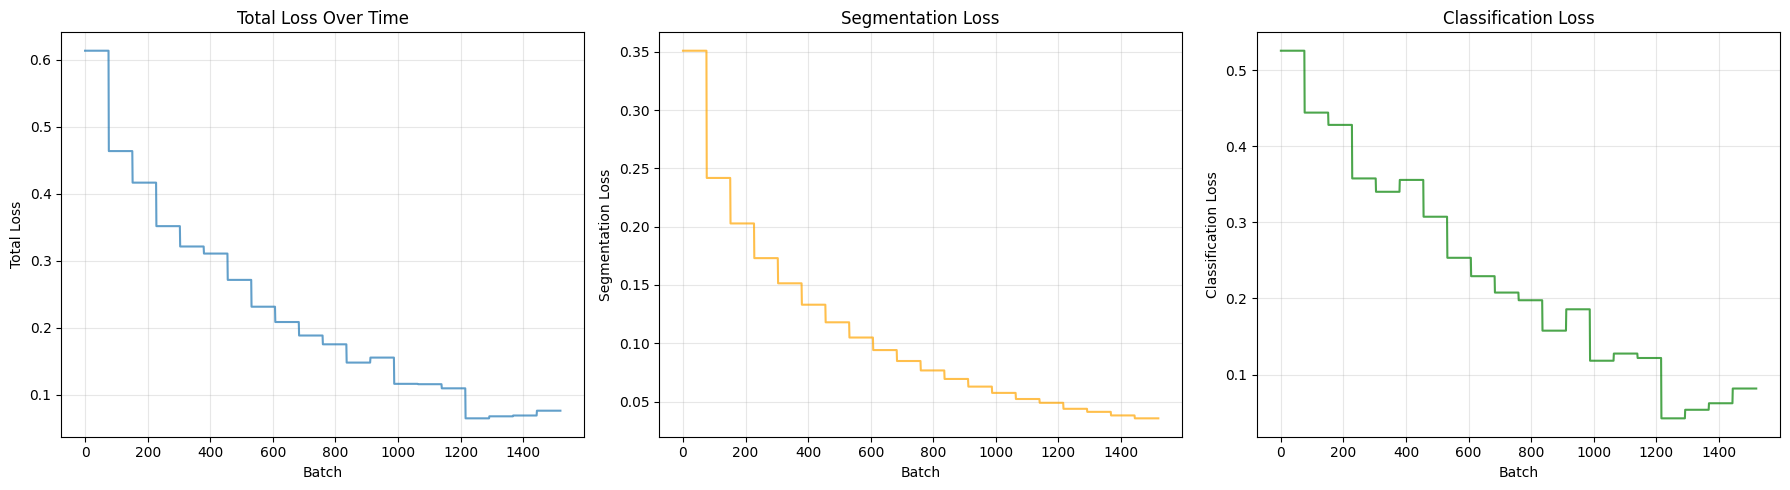

In [6]:
def plot_training_curves(history):
    """Plot training loss curves"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Total loss
    axes[0].plot(history['total_loss'], alpha=0.7)
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Total Loss')
    axes[0].set_title('Total Loss Over Time')
    axes[0].grid(True, alpha=0.3)
    
    # Segmentation loss
    axes[1].plot(history['seg_loss'], alpha=0.7, color='orange')
    axes[1].set_xlabel('Batch')
    axes[1].set_ylabel('Segmentation Loss')
    axes[1].set_title('Segmentation Loss')
    axes[1].grid(True, alpha=0.3)
    
    # Classification loss
    axes[2].plot(history['clf_loss'], alpha=0.7, color='green')
    axes[2].set_xlabel('Batch')
    axes[2].set_ylabel('Classification Loss')
    axes[2].set_title('Classification Loss')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

## 7. Evaluation: Comprehensive Performance Metrics


🔍 EVALUATING STANDARD U-NET (Manual Metrics)


Evaluating: 100%|██████████| 76/76 [00:07<00:00,  9.62it/s]



=======================🎯 SEGMENTATION METRICS ========================
  IoU: 0.3545
  Dice: 0.5235
  Pixel Accuracy: 0.9947
  Sensitivity: 0.7743
  Specificity: 0.9956
  Precision: 0.3954

======================🎯 CLASSIFICATION METRICS =======================
  Accuracy: 0.5280
  Precision: 0.3881
  Recall: 1.0000
  F1-Score: 0.5591
  ROC-AUC: 0.9984

=========================📊 CONFUSION MATRIX ==========================


/tmp/ipykernel_14682/3317676346.py:91: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


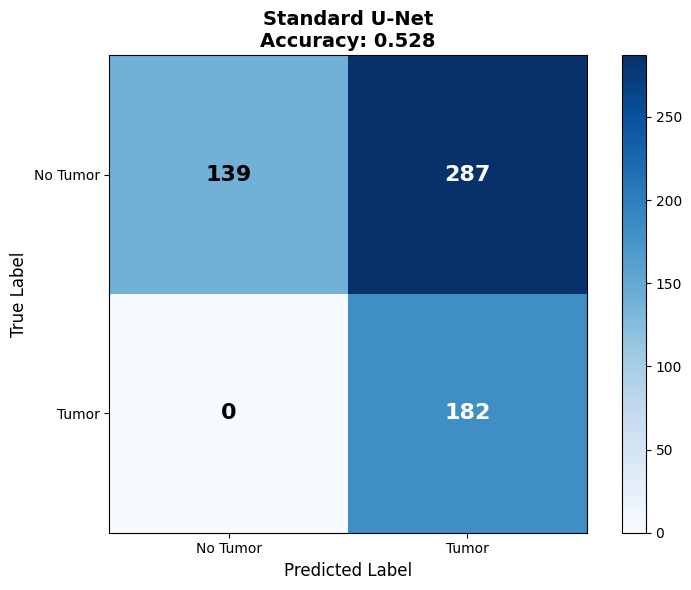


=============================📈 ROC CURVE =============================


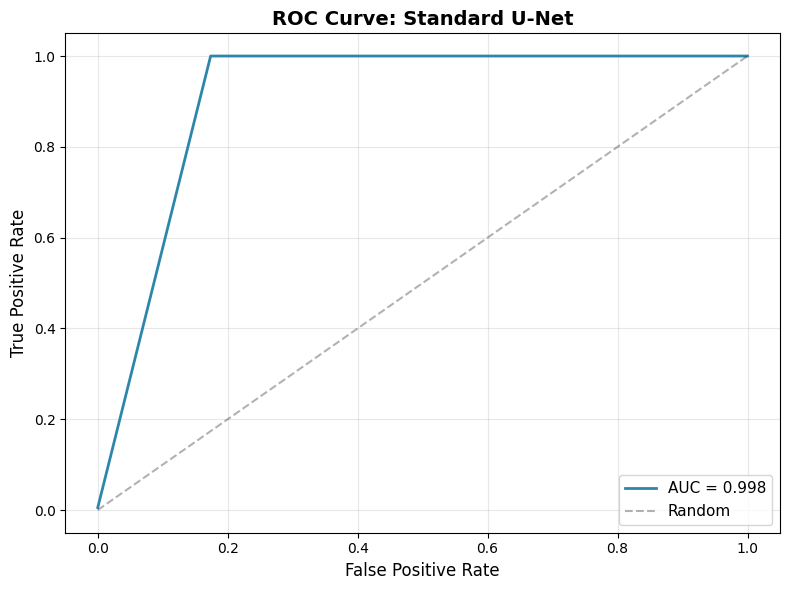

In [7]:
def compute_segmentation_metrics(pred_masks, true_masks, threshold=0.5):
    """Compute segmentation metrics manually"""
    pred_binary = (pred_masks > threshold).float()
    true_binary = (true_masks > threshold).float()
    
    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)
    
    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()
    
    epsilon = 1e-7
    
    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)
    
    return {
        'IoU': iou,
        'Dice': dice,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }


def compute_classification_metrics_manual(pred_probs, true_labels, threshold=0.5):
    """Compute classification metrics WITHOUT sklearn"""
    pred_probs_np = pred_probs.cpu().numpy().flatten()
    true_labels_np = true_labels.cpu().numpy().flatten()
    pred_labels = (pred_probs_np > threshold).astype(int)
    
    # Manual confusion matrix
    TP = np.sum((pred_labels == 1) & (true_labels_np == 1))
    TN = np.sum((pred_labels == 0) & (true_labels_np == 0))
    FP = np.sum((pred_labels == 1) & (true_labels_np == 0))
    FN = np.sum((pred_labels == 0) & (true_labels_np == 1))
    
    cm = np.array([[TN, FP], [FN, TP]])
    
    epsilon = 1e-7
    accuracy = (TP + TN) / (TP + TN + FP + FN + epsilon)
    precision = TP / (TP + FP + epsilon)
    recall = TP / (TP + FN + epsilon)
    f1_score = 2 * (precision * recall) / (precision + recall + epsilon)
    
    # Manual ROC-AUC calculation
    roc_auc = compute_roc_auc_manual(true_labels_np, pred_probs_np)
    
    return {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1_score,
        'ROC_AUC': roc_auc
    }


def compute_roc_auc_manual(y_true, y_scores):
    """Manual ROC-AUC calculation (trapezoidal rule)"""
    # Sort by score
    desc_score_indices = np.argsort(y_scores)[::-1]
    y_scores = y_scores[desc_score_indices]
    y_true = y_true[desc_score_indices]
    
    # Calculate TPR and FPR at each threshold
    tps = np.cumsum(y_true)
    fps = np.cumsum(1 - y_true)
    
    total_pos = np.sum(y_true)
    total_neg = len(y_true) - total_pos
    
    if total_pos == 0 or total_neg == 0:
        return 0.0
    
    tpr = tps / total_pos
    fpr = fps / total_neg
    
    # Add (0,0) and (1,1) points
    tpr = np.concatenate([[0], tpr])
    fpr = np.concatenate([[0], fpr])
    
    # Calculate AUC using trapezoidal rule
    auc = np.trapz(tpr, fpr)
    
    return auc


def evaluate_model(model, dataloader):
    """Comprehensive evaluation WITHOUT sklearn"""
    model.eval()
    
    all_seg_preds = []
    all_seg_true = []
    all_clf_preds = []
    all_clf_true = []
    
    print("\n" + "="*70)
    print("🔍 EVALUATING STANDARD U-NET (Manual Metrics)")
    print("="*70)
    
    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            
            seg_logits, clf_logits = model(images)
            
            seg_probs = torch.sigmoid(seg_logits)
            clf_probs = torch.sigmoid(clf_logits)
            
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())
            all_clf_preds.append(clf_probs.cpu())
            all_clf_true.append(clf_labels.cpu())
    
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)
    clf_preds = torch.cat(all_clf_preds, dim=0)
    clf_true = torch.cat(all_clf_true, dim=0)
    
    # Compute metrics
    seg_metrics = compute_segmentation_metrics(seg_preds, seg_true)
    clf_metrics = compute_classification_metrics_manual(clf_preds, clf_true)
    
    # Print results
    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  IoU: {seg_metrics['IoU']:.4f}")
    print(f"  Dice: {seg_metrics['Dice']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity: {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")
    
    print("\n" + "🎯 CLASSIFICATION METRICS ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"  ROC-AUC: {clf_metrics['ROC_AUC']:.4f}")
    
    # Manual Confusion Matrix Plot
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))
    cm = clf_metrics['Confusion_Matrix']
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    
    # Add colorbar
    plt.colorbar(im, ax=ax)
    
    # Set ticks and labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center", color="black" if cm[i, j] < cm.max()/2 else "white",
                          fontsize=16, fontweight='bold')
    
    ax.set_title(f"Standard U-Net\nAccuracy: {clf_metrics['Accuracy']:.3f}", fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Manual ROC Curve
    print("\n" + "📈 ROC CURVE ".center(70, "="))
    pred_probs_np = clf_preds.cpu().numpy().flatten()
    true_labels_np = clf_true.cpu().numpy().flatten()
    
    # Calculate ROC points
    thresholds = np.linspace(1, 0, 100)
    tpr_list = []
    fpr_list = []
    
    for thresh in thresholds:
        pred_labels = (pred_probs_np >= thresh).astype(int)
        TP = np.sum((pred_labels == 1) & (true_labels_np == 1))
        TN = np.sum((pred_labels == 0) & (true_labels_np == 0))
        FP = np.sum((pred_labels == 1) & (true_labels_np == 0))
        FN = np.sum((pred_labels == 0) & (true_labels_np == 1))
        
        tpr = TP / (TP + FN + 1e-7)
        fpr = FP / (FP + TN + 1e-7)
        
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_list, tpr_list, linewidth=2, label=f'AUC = {clf_metrics["ROC_AUC"]:.3f}', color='#2E86AB')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random', linewidth=1.5)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve: Standard U-Net', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70 + "\n")
    
    return seg_metrics, clf_metrics


# Run evaluation
seg_metrics, clf_metrics = evaluate_model(standard_unet, train_loader)

## 8. Sample Predictions Visualization

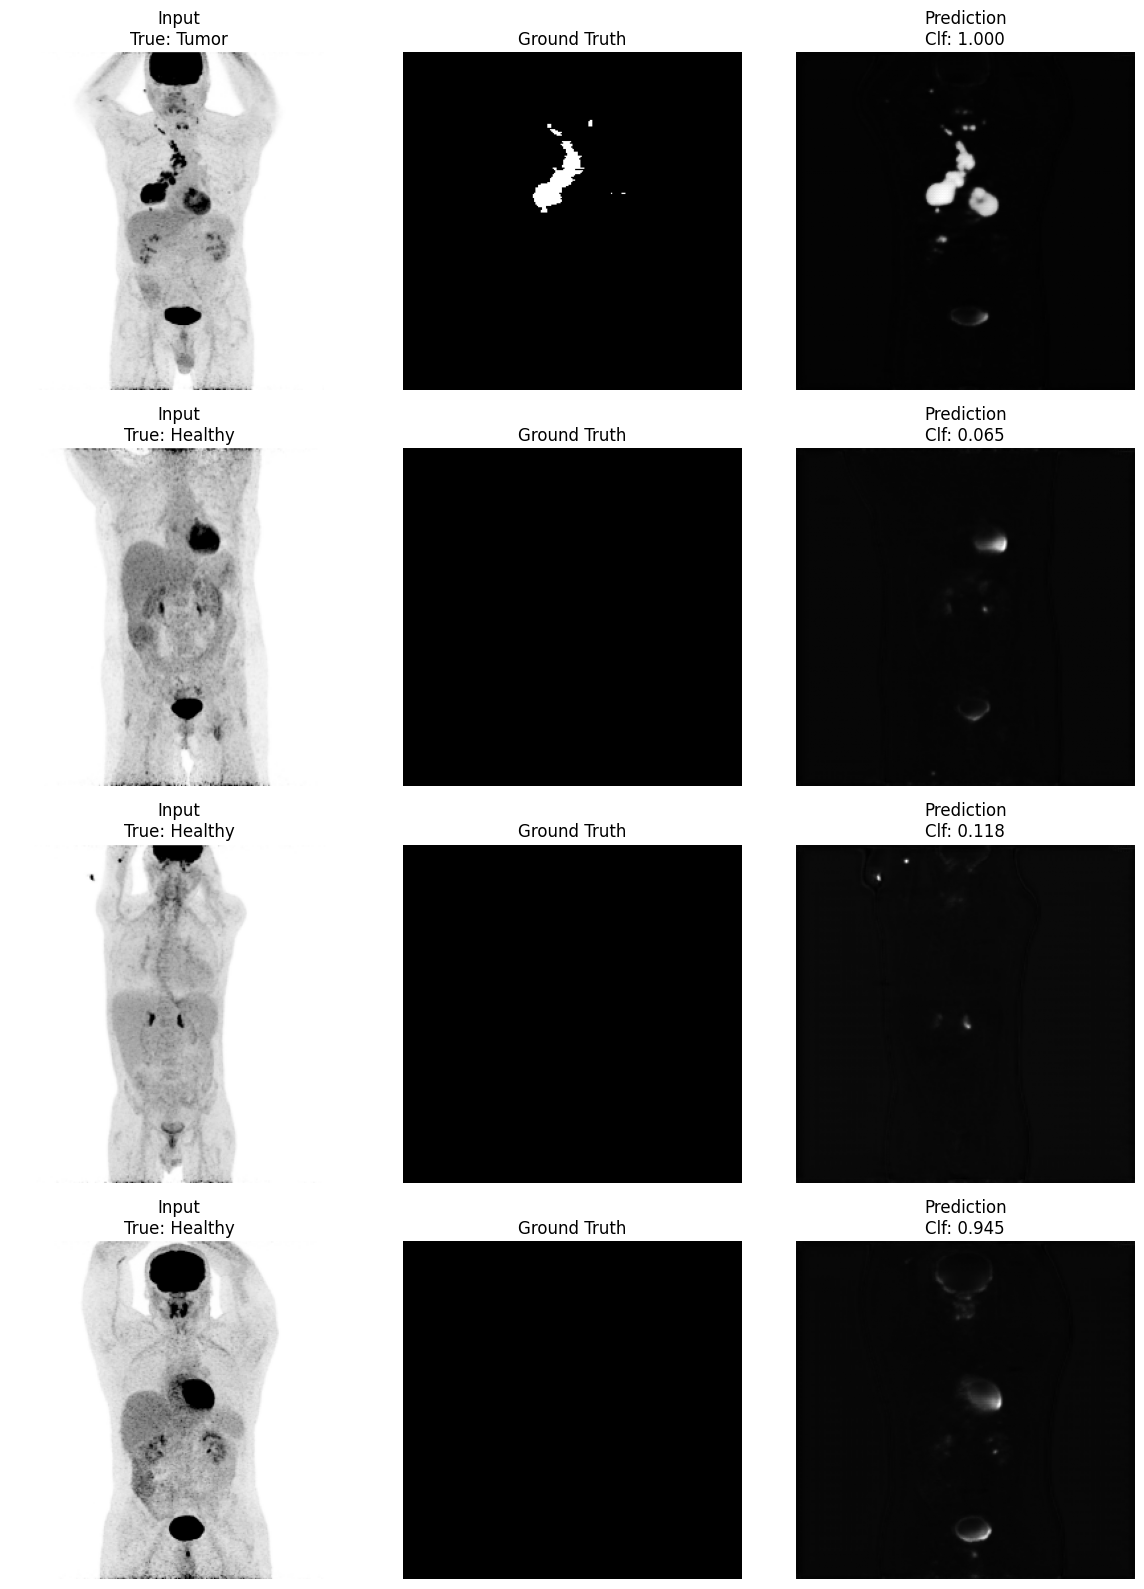

In [8]:
def visualize_predictions(model, dataloader, num_samples=4):
    """Visualize sample predictions"""
    model.eval()
    
    images, masks, labels = next(iter(dataloader))
    images = images[:num_samples].to(device)
    masks = masks[:num_samples]
    labels = labels[:num_samples]
    
    with torch.no_grad():
        seg_logits, clf_logits = model(images)
        seg_preds = torch.sigmoid(seg_logits).cpu()
        clf_preds = torch.sigmoid(clf_logits).cpu()
    
    images = images.cpu()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(num_samples):
        # Input
        axes[i, 0].imshow(images[i, 0], cmap='gray')
        axes[i, 0].set_title(f'Input\nTrue: {"Tumor" if labels[i] else "Healthy"}')
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(masks[i, 0], cmap='gray')
        axes[i, 1].set_title('Ground Truth')
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(seg_preds[i, 0], cmap='gray')
        axes[i, 2].set_title(f'Prediction\nClf: {clf_preds[i].item():.3f}')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(standard_unet, train_loader, num_samples=4)